## Proyecto Aprendizaje Profundo

- Alexis Carrera


## Cargar Base De Datos

## Instalar e importar bibliotecas


In [262]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## PARAMETROS

In [263]:
# Configuración
TICKER_DIR = "./data_augmentation"  # Directorio donde están los archivos CSV
LOOKBACK = 60      # Ventana de lookback para las secuencias Reviso 3 meses
PREDICTION_HORIZON = 0  # Predecir 3 meses (60 dias habiles)
BATCH_SIZE = 64
HIDDEN_SIZE = 128
NUM_LAYERS = 3
DROPOUT = 0.3
LEARNING_RATE = 0.001
NUM_EPOCHS = 200
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
NUM_WORKERS = 8
STEP_SIZE = 5

## Procesamiento de Datos

In [264]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
import os

class StockDataset(Dataset):
    def __init__(self, ticker_files, lookback=60, prediction_horizon=63, step_size=STEP_SIZE):
        """
        Dataset que carga datos bajo demanda para ahorrar RAM

        Args:
            ticker_files: Lista de archivos CSV de tickers
            lookback: Días históricos para cada secuencia
            prediction_horizon: Horizonte de predicción
            step_size: Saltos entre secuencias
        """
        self.lookback = lookback
        self.prediction_horizon = prediction_horizon
        self.step_size = step_size
        self.ticker_files = ticker_files

        # Pre-calcular índices y metadatos sin cargar todos los datos
        self.indices = []  # (ticker_index, start_index) para cada secuencia
        self.scalers = {}
        self.ticker_dfs = {}  # Cache para DataFrames ya cargados
        self.ticker_features = {}  # Cache para features escalados

        self._precompute_indices()

    def _precompute_indices(self):
        """Pre-calcula todos los índices válidos sin cargar datos completos"""
        total_sequences = 0

        for ticker_idx, ticker_file in enumerate(self.ticker_files):
            try:
                # Cargar solo para obtener metadatos
                df = pd.read_csv(ticker_file, nrows=100)  # Solo leer primeras filas para estructura

                if 'Target_3M_Return' not in df.columns:
                    print(f"Saltando {ticker_file}: no tiene Target_3M_Return")
                    continue

                # Leer número total de filas eficientemente
                with open(ticker_file, 'r') as f:
                    total_rows = sum(1 for line in f) - 1  # Restar header

                # Calcular índices válidos para este ticker
                valid_indices = range(
                    self.lookback,
                    total_rows - self.prediction_horizon,
                    self.step_size
                )

                # Almacenar metadatos
                for start_idx in valid_indices:
                    self.indices.append((ticker_idx, start_idx))

                total_sequences += len(valid_indices)
                # print(f"Ticker {ticker_file}: {len(valid_indices)} secuencias potenciales")

            except Exception as e:
                print(f"Error procesando {ticker_file}: {e}")
                continue

        print(f"Total de secuencias a generar bajo demanda: {total_sequences}")

    def _load_ticker_data(self, ticker_idx):
        """Carga y procesa datos de un ticker específico (con cache)"""
        if ticker_idx in self.ticker_dfs:
            return self.ticker_dfs[ticker_idx], self.ticker_features[ticker_idx]

        ticker_file = self.ticker_files[ticker_idx]

        # Cargar DataFrame completo
        df = pd.read_csv(ticker_file)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)

        # Extraer features
        features = df.drop(['Date', 'Target_Direction', 'Target_3M_Return'],
                          axis=1, errors='ignore')

        # Escalar
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # Guardar en cache
        self.ticker_dfs[ticker_idx] = df
        self.ticker_features[ticker_idx] = features_scaled
        self.scalers[ticker_idx] = scaler

        return df, features_scaled

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Obtener metadatos de la secuencia
        ticker_idx, start_idx = self.indices[idx]

        # Cargar datos del ticker (se cachean después de primera carga)
        df, features_scaled = self._load_ticker_data(ticker_idx)

        # Extraer secuencia
        end_idx = start_idx
        start_seq_idx = end_idx - self.lookback

        seq = features_scaled[start_seq_idx:end_idx]
        target = df['Target_3M_Return'].iloc[end_idx + self.prediction_horizon - 1]

        # Convertir a tensores
        seq_tensor = torch.FloatTensor(seq)
        target_tensor = torch.FloatTensor([target])

        return seq_tensor, target_tensor

    def clear_cache(self):
        """Liberar memoria del cache"""
        self.ticker_dfs.clear()
        self.ticker_features.clear()
        self.scalers.clear()

In [268]:
# Módulo de datos para Lightning
class StockDataModule(pl.LightningDataModule):
    def __init__(self, ticker_files, lookback=LOOKBACK, prediction_horizon=PREDICTION_HORIZON, batch_size=BATCH_SIZE):
        super().__init__()
        self.ticker_files = ticker_files
        self.lookback = lookback
        self.prediction_horizon = prediction_horizon
        self.batch_size = batch_size

    def setup(self, stage=None):
        full_dataset = StockDataset(self.ticker_files, self.lookback, self.prediction_horizon)

        # Dividir dataset
        train_size = int(len(full_dataset) * TRAIN_RATIO)
        val_size = int(len(full_dataset) * VAL_RATIO)
        test_size = len(full_dataset) - train_size - val_size

        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size]
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS)


In [269]:
# Modelo base RNN
class BaseRNN(pl.LightningModule):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS,
                 dropout=DROPOUT, learning_rate=LEARNING_RATE):
        super().__init__()
        self.save_hyperparameters()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Inicializar estado oculto
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pasar por RNN
        out, _ = self.rnn(x, h0)

        # Tomar la última salida de la secuencia
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        self.log('train_mae', mae,on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss,  on_epoch=True)
        mae = torch.abs(y_hat - y).mean()
        self.log('val_mae', mae,  on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        self.log('test_mae', mae, on_epoch=True, on_step=False)
        return loss


In [270]:
# Modelo LSTM
class StockLSTM(pl.LightningModule):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS,
                 dropout=DROPOUT, learning_rate=LEARNING_RATE):
        super().__init__()
        self.save_hyperparameters()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Inicializar estados oculto y de celda
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pasar por LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Tomar la última salida de la secuencia
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        self.log('train_mae', mae,on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        self.log('val_mae', mae,  on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        self.log('test_mae', mae, on_epoch=True, on_step=False)
        return loss


In [271]:
# Modelo GRU
class StockGRU(pl.LightningModule):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS,
                 dropout=DROPOUT, learning_rate=LEARNING_RATE):
        super().__init__()
        self.save_hyperparameters()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Inicializar estado oculto
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pasar por GRU
        out, _ = self.gru(x, h0)

        # Tomar la última salida de la secuencia
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        self.log('train_mae', mae,on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        self.log('val_mae', mae,  on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        mae = torch.abs(y_hat - y).mean()
        self.log('test_mae', mae, on_epoch=True, on_step=False)
        return loss

In [272]:
# Obtener lista de archivos
ticker_files = [os.path.join(TICKER_DIR, f) for f in os.listdir(TICKER_DIR)
                if f.endswith('_completo_arreglado.csv')]

In [273]:
ticker_files

['./data_augmentation/GOOGL_completo_arreglado.csv',
 './data_augmentation/RL_completo_arreglado.csv',
 './data_augmentation/CSCO_completo_arreglado.csv',
 './data_augmentation/IPG_completo_arreglado.csv',
 './data_augmentation/UAL_completo_arreglado.csv',
 './data_augmentation/EMR_completo_arreglado.csv',
 './data_augmentation/ROST_completo_arreglado.csv',
 './data_augmentation/AES_completo_arreglado.csv',
 './data_augmentation/HD_completo_arreglado.csv',
 './data_augmentation/ZTS_completo_arreglado.csv',
 './data_augmentation/NXPI_completo_arreglado.csv',
 './data_augmentation/BX_completo_arreglado.csv',
 './data_augmentation/DG_completo_arreglado.csv',
 './data_augmentation/FI_completo_arreglado.csv',
 './data_augmentation/KMI_completo_arreglado.csv',
 './data_augmentation/AXON_completo_arreglado.csv',
 './data_augmentation/TJX_completo_arreglado.csv',
 './data_augmentation/GS_completo_arreglado.csv',
 './data_augmentation/PSX_completo_arreglado.csv',
 './data_augmentation/MKC_compl

In [274]:
import pandas as pd
minimo = 80
ticker_data = ""
for ticker_file in ticker_files:  # Revisa los primeros 5 archivos
    df = pd.read_csv(ticker_file)
    if minimo < df.columns.shape[0]:
        # print(f"Archivo: {ticker_file}, Columnas: {df.columns.shape}, Forma: {df.shape}")
        minimo = df.columns.shape[0]
        # print(f"Archivo: {ticker_file}, Columnas: {df.columns.shape}, Forma: {df.shape}")
        ticker_data = ticker_file
print(minimo)
print(ticker_data)

91
./data_augmentation/GOOGL_completo_arreglado.csv


In [275]:
ticker_files[0]

'./data_augmentation/GOOGL_completo_arreglado.csv'

In [ ]:
print(f"Encontrados {len(ticker_files)} archivos de tickers")

# Crear módulo de datos
data_module = StockDataModule(ticker_files)
data_module.setup()

print(f"Número de secuencias de entrenamiento: {len(data_module.train_dataset)}")
print(f"Número de secuencias de validación: {len(data_module.val_dataset)}")
print(f"Número de secuencias de prueba: {len(data_module.test_dataset)}")

Encontrados 503 archivos de tickers
Total de secuencias a generar bajo demanda: 73038
Número de secuencias de entrenamiento: 58430
Número de secuencias de validación: 7303
Número de secuencias de prueba: 7305


In [277]:
# Modelo
input_size = data_module.train_dataset[0][0].shape[1]  # Número de características
input_size

88

In [278]:
data_module.train_dataset[0]

(tensor([[ 1.3812,  1.4569,  1.3314,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.3030,  1.4506,  1.3451,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.2741,  1.4358,  1.3634,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-1.1168, -0.9150, -0.7920,  ...,  0.0000,  0.0000,  0.0000],
         [-1.1857, -1.0000, -0.8434,  ...,  0.0000,  0.0000,  0.0000],
         [-1.2264, -1.0774, -0.8852,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor([63.3059]))

In [279]:
# Inicialización del modulo lightning
rnn_model = BaseRNN(input_size=input_size, learning_rate= LEARNING_RATE)

callback_check = ModelCheckpoint(save_top_k=1, mode="min", monitor="val_mae") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stopping = EarlyStopping(monitor='val_mae', patience=10, mode='min')

logger = CSVLogger(save_dir="logs/", name="rnn-proyecto-final")

In [280]:

trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, callback_check, callback_tqdm],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices="auto",  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    deterministic=False,
                    log_every_n_steps=10)

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [281]:
start_time = time.time()
trainer.fit(model = rnn_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Total de secuencias a generar bajo demanda: 73038


┏━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type    ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ rnn     │ RNN     │ 94.0 K │ train │
│ 1 │ fc      │ Linear  │    129 │ train │
│ 2 │ dropout │ Dropout │      0 │ train │
└───┴─────────┴─────────┴────────┴───────┘

Trainable params: 94.1 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 94.1 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 3                                                                                           
Modules in eval mode: 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Tiempo de entrenamiento en minutos: 27.04


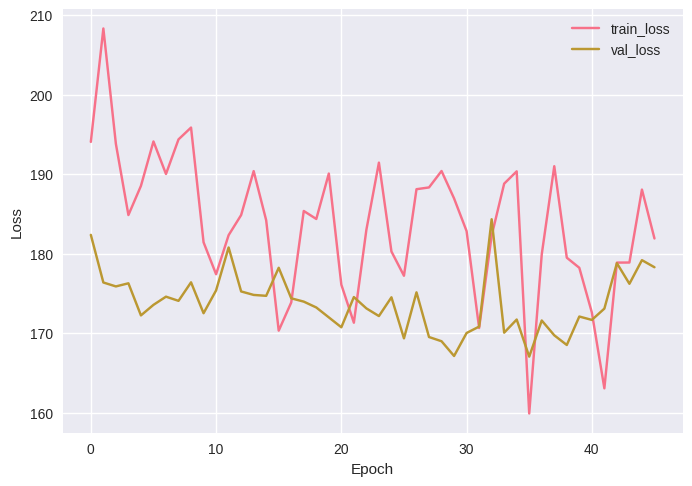

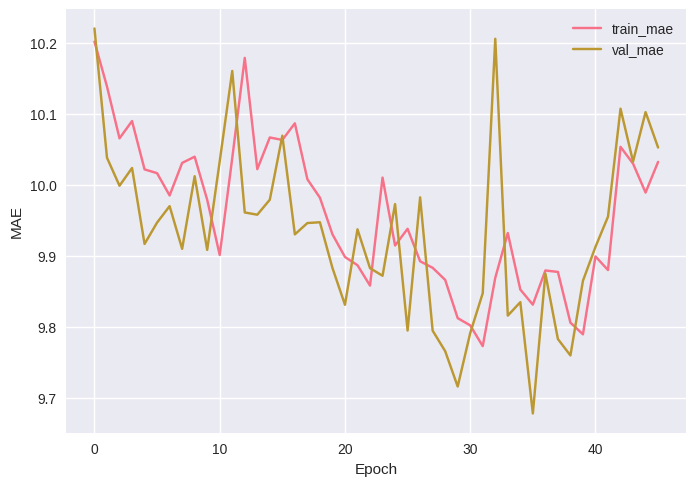

In [282]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_mae", "val_mae"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="MAE"
)

plt.show()



In [283]:
# Evaluación
trainer.test(model = rnn_model, datamodule = data_module, ckpt_path = 'best')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/rnn-proyecto-final/version_7/checkpoints/epoch=35-step=32868.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/rnn-proyecto-final/version_7/checkpoints/epoch=35-step=32868.ckpt


Total de secuencias a generar bajo demanda: 73038


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     175.9880828857422     │
│         test_mae          │     9.786550521850586     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 175.9880828857422, 'test_mae': 9.786550521850586}]

In [284]:
# Inicialización del modulo lightning
lstm_model = StockLSTM(input_size=input_size, learning_rate= LEARNING_RATE)

callback_check = ModelCheckpoint(save_top_k=1, mode="min", monitor="val_mae") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stopping = EarlyStopping(monitor='val_mae', patience=10, mode='min')

logger = CSVLogger(save_dir="logs/", name="lstm-proyecto-final")

In [285]:

trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, callback_check, callback_tqdm],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices="auto",  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    deterministic=False,
                    log_every_n_steps=10)

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [286]:
start_time = time.time()
trainer.fit(model = lstm_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Total de secuencias a generar bajo demanda: 73038


┏━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type    ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ lstm    │ LSTM    │  375 K │ train │
│ 1 │ fc      │ Linear  │    129 │ train │
│ 2 │ dropout │ Dropout │      0 │ train │
└───┴─────────┴─────────┴────────┴───────┘

Trainable params: 375 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 375 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 3                                                                                           
Modules in eval mode: 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Tiempo de entrenamiento en minutos: 40.97


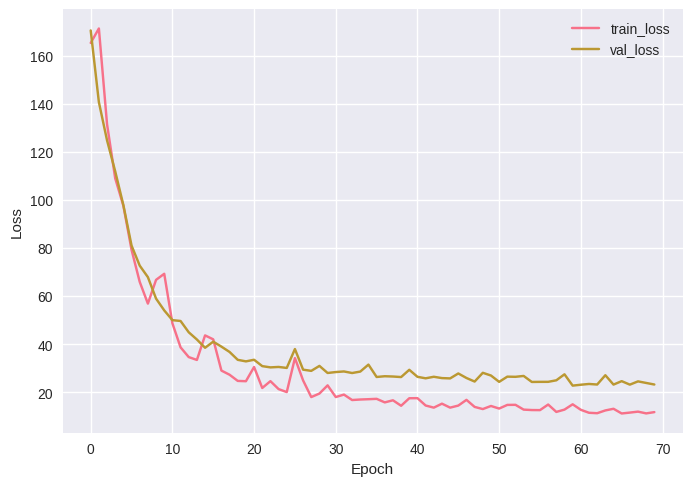

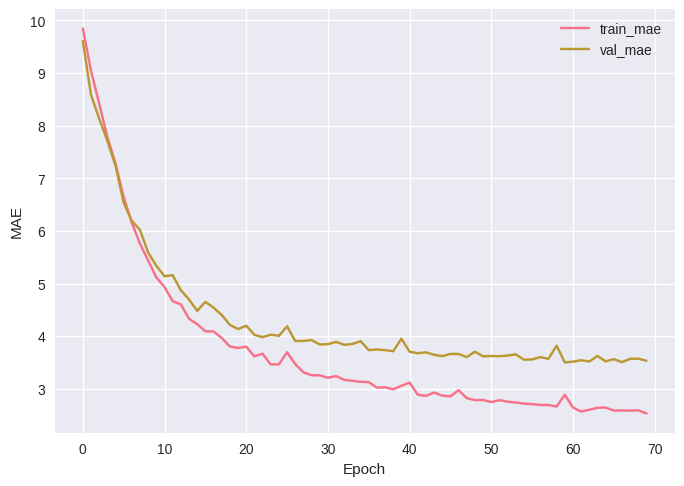

In [287]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_mae", "val_mae"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="MAE"
)

plt.show()

In [288]:
# Evaluación
trainer.test(model = lstm_model, datamodule = data_module, ckpt_path = 'best')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/lstm-proyecto-final/version_4/checkpoints/epoch=59-step=54780.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/lstm-proyecto-final/version_4/checkpoints/epoch=59-step=54780.ckpt


Total de secuencias a generar bajo demanda: 73038


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    13.605955123901367     │
│         test_mae          │     2.489901065826416     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 13.605955123901367, 'test_mae': 2.489901065826416}]

In [289]:
# Inicialización del modulo lightning
gru_model = StockGRU(input_size=input_size, learning_rate= LEARNING_RATE)

callback_check = ModelCheckpoint(save_top_k=1, mode="min", monitor="val_mae") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stopping = EarlyStopping(monitor='val_mae', patience=10, mode='min')

logger = CSVLogger(save_dir="logs/", name="gru-proyecto-final")

In [290]:
trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, callback_check, callback_tqdm],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices="auto",  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    deterministic=False,
                    log_every_n_steps=10)

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [291]:
start_time = time.time()
trainer.fit(model = gru_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Total de secuencias a generar bajo demanda: 73038


┏━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type    ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ gru     │ GRU     │  281 K │ train │
│ 1 │ fc      │ Linear  │    129 │ train │
│ 2 │ dropout │ Dropout │      0 │ train │
└───┴─────────┴─────────┴────────┴───────┘

Trainable params: 281 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 281 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 3                                                                                           
Modules in eval mode: 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Tiempo de entrenamiento en minutos: 36.49


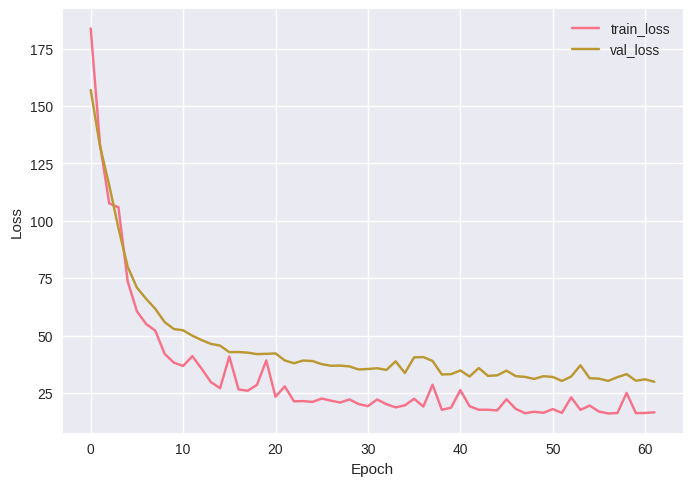

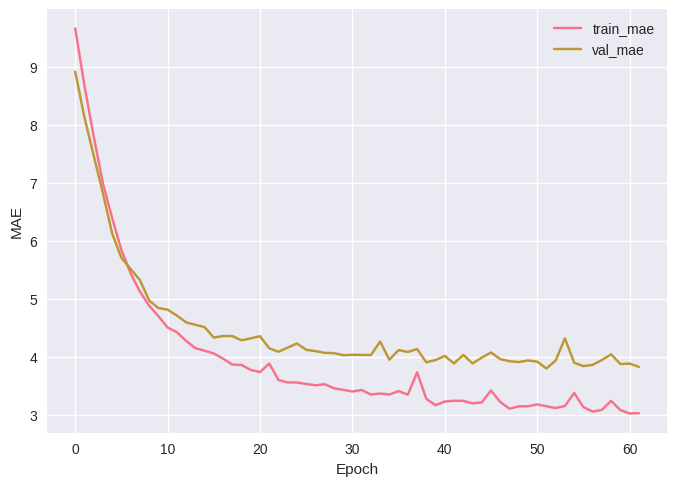

In [292]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_mae", "val_mae"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="MAE"
)

plt.show()

In [293]:
trainer.test(model = gru_model, datamodule = data_module, ckpt_path = 'best')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/gru-proyecto-final/version_4/checkpoints/epoch=51-step=47476.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/gru-proyecto-final/version_4/checkpoints/epoch=51-step=47476.ckpt


Total de secuencias a generar bajo demanda: 73038


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    13.080046653747559     │
│         test_mae          │    2.7000796794891357     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 13.080046653747559, 'test_mae': 2.7000796794891357}]

## Predicción

In [294]:
# Para obtener también los valores reales y comparar
def get_predictions_with_actuals(model, dataloader):
    """
    Obtiene predicciones y valores reales para evaluación
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x = x
            y = y

            preds = model(x)
            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy().flatten()
    all_targets = torch.cat(all_targets).numpy().flatten()

    return all_preds, all_targets

## RNN EVALUACIÓN

In [ ]:
# Obtener el dataloader de test
test_dataloader = data_module.test_dataloader()

# Obtener predicciones y valores reales
predicted, actual = get_predictions_with_actuals(rnn_model, test_dataloader)

print(predicted)
print(actual)

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print(f"MAE: {mae:.2f}%")
print(f"RMSE: {rmse:.2f}%")
print(f"MAPE: {mape:.2f}%")

[  6.219655    3.763927  -10.084649  ...  14.918857   -1.4324703
 -10.018905 ]
[ 25.283772  -7.761882 -13.582063 ...  10.0776     3.121496 -13.221619]
MAE: 9.69%
RMSE: 12.96%
MAPE: inf%


<ipython-input-295-dc9bb4487afa>:21: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100


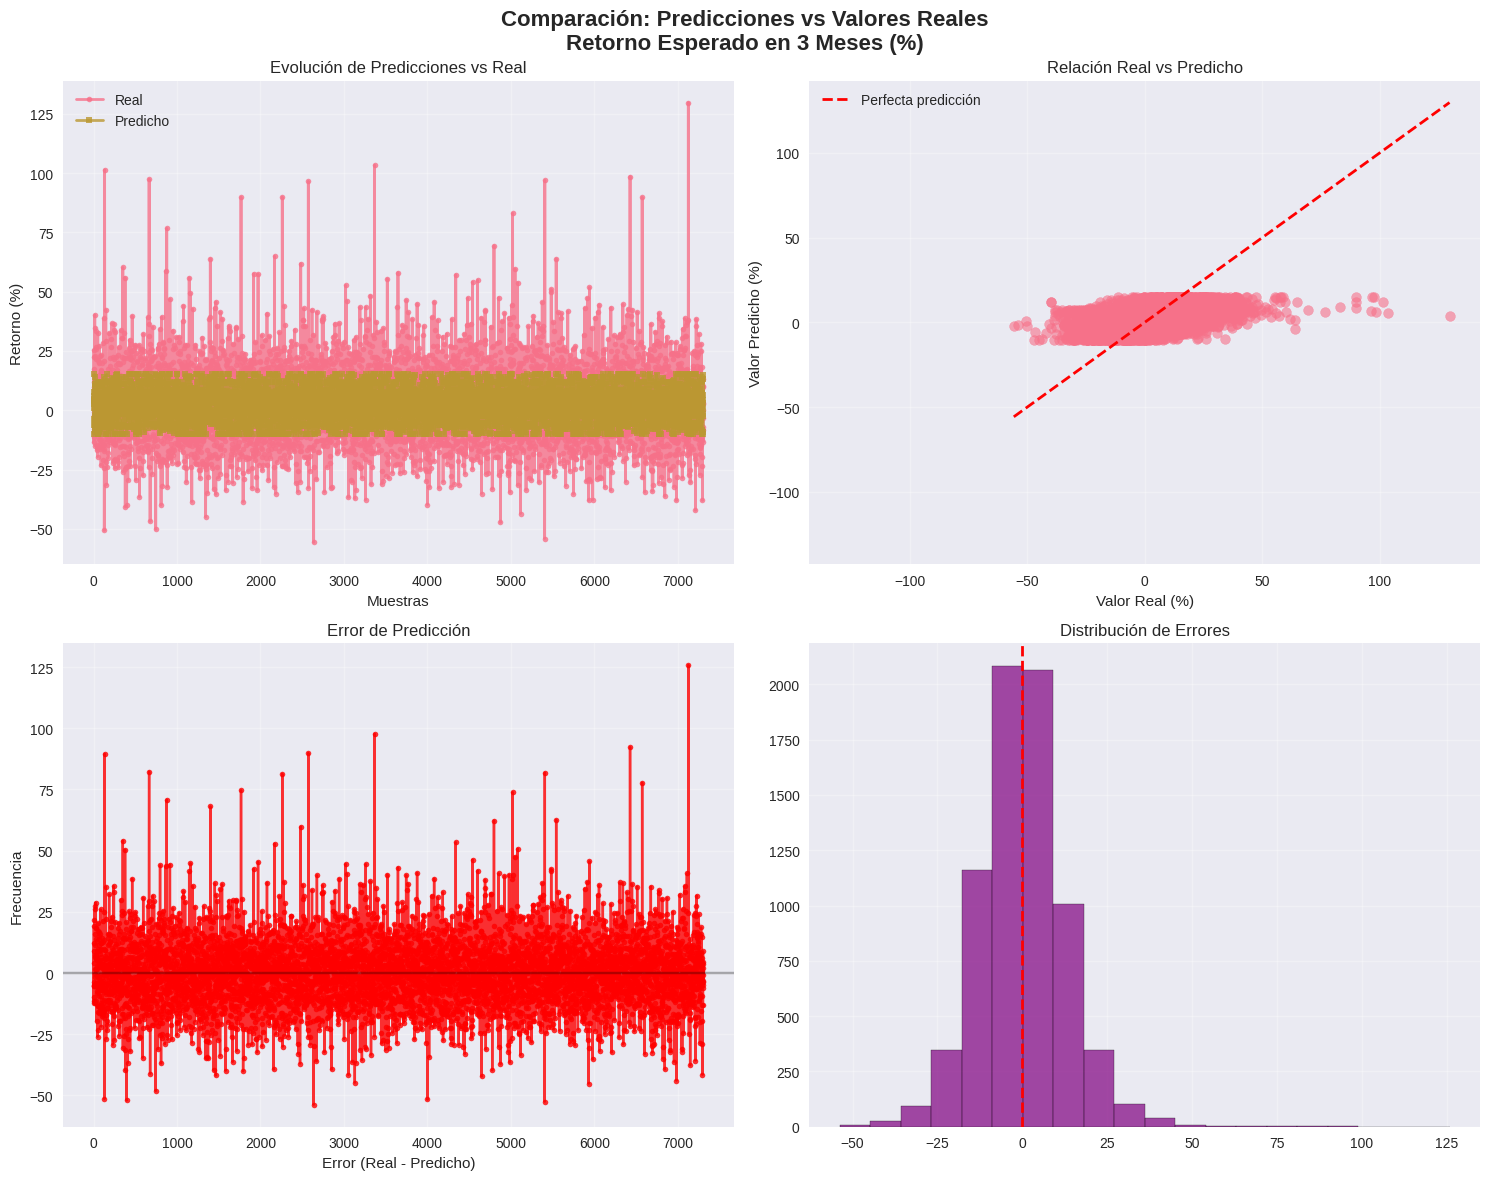

In [296]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación: Predicciones vs Valores Reales\nRetorno Esperado en 3 Meses (%)',
             fontsize=16, fontweight='bold')

# 1. Gráfico de líneas comparativo
axes[0, 0].plot(actual, label='Real', marker='o', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].plot(predicted, label='Predicho', marker='s', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Muestras')
axes[0, 0].set_ylabel('Retorno (%)')
axes[0, 0].set_title('Evolución de Predicciones vs Real')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot con línea de perfecta predicción
max_val = max(max(predicted), max(actual))
min_val = min(min(predicted), min(actual))
limit = max(abs(max_val), abs(min_val)) * 1.1

axes[0, 1].scatter(actual, predicted, alpha=0.6, s=50)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfecta predicción')
axes[0, 1].set_xlabel('Valor Real (%)')
axes[0, 1].set_ylabel('Valor Predicho (%)')
axes[0, 1].set_title('Relación Real vs Predicho')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-limit, limit)
axes[0, 1].set_ylim(-limit, limit)

# 3. Gráfico de error (diferencia)
error = np.array(actual) - np.array(predicted)
axes[1, 0].plot(error, marker='o', markersize=4, color='red', alpha=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Muestras')
axes[1, 0].set_ylabel('Error (Real - Predicho)')
axes[1, 0].set_title('Error de Predicción')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histograma de errores
axes[1, 1].hist(error, bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Error (Real - Predicho)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Errores')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## LSTM EVALUACIÓN

In [ ]:
# Obtener el dataloader de test
test_dataloader = data_module.test_dataloader()

# Obtener predicciones y valores reales
predicted, actual = get_predictions_with_actuals(lstm_model, test_dataloader)

print(predicted)
print(actual)

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print(f"MAE: {mae:.2f}%")
print(f"RMSE: {rmse:.2f}%")
print(f"MAPE: {mape:.2f}%")

[ 26.86298    -5.438018  -11.803518  ...   8.221716   -2.6297908
  -7.083866 ]
[ 25.283772  -7.761882 -13.582063 ...  10.0776     3.121496 -13.221619]
MAE: 2.42%
RMSE: 3.46%
MAPE: inf%


<ipython-input-297-10b137f4754a>:21: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100


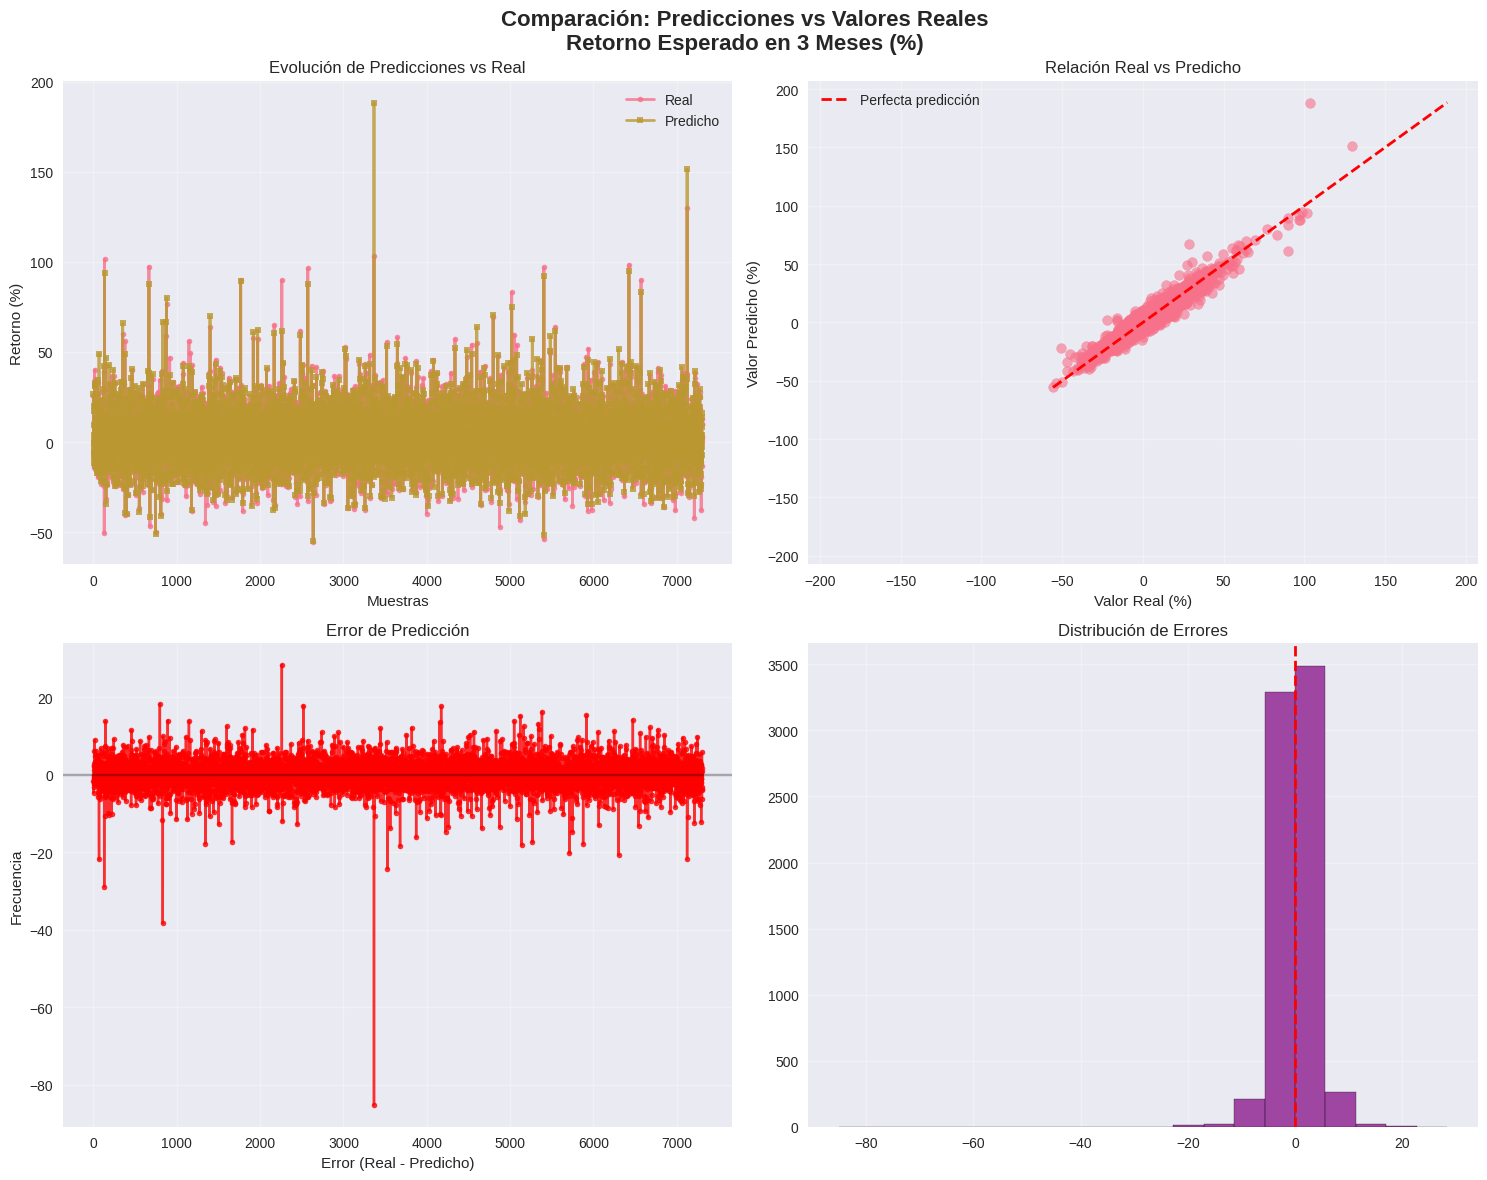

In [298]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación: Predicciones vs Valores Reales\nRetorno Esperado en 3 Meses (%)',
             fontsize=16, fontweight='bold')

# 1. Gráfico de líneas comparativo
axes[0, 0].plot(actual, label='Real', marker='o', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].plot(predicted, label='Predicho', marker='s', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Muestras')
axes[0, 0].set_ylabel('Retorno (%)')
axes[0, 0].set_title('Evolución de Predicciones vs Real')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot con línea de perfecta predicción
max_val = max(max(predicted), max(actual))
min_val = min(min(predicted), min(actual))
limit = max(abs(max_val), abs(min_val)) * 1.1

axes[0, 1].scatter(actual, predicted, alpha=0.6, s=50)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfecta predicción')
axes[0, 1].set_xlabel('Valor Real (%)')
axes[0, 1].set_ylabel('Valor Predicho (%)')
axes[0, 1].set_title('Relación Real vs Predicho')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-limit, limit)
axes[0, 1].set_ylim(-limit, limit)

# 3. Gráfico de error (diferencia)
error = np.array(actual) - np.array(predicted)
axes[1, 0].plot(error, marker='o', markersize=4, color='red', alpha=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Muestras')
axes[1, 0].set_ylabel('Error (Real - Predicho)')
axes[1, 0].set_title('Error de Predicción')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histograma de errores
axes[1, 1].hist(error, bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Error (Real - Predicho)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Errores')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## GRU EVALUACIÓN

In [ ]:
# Obtener el dataloader de test
test_dataloader = data_module.test_dataloader()

# Obtener predicciones y valores reales
predicted, actual = get_predictions_with_actuals(gru_model, test_dataloader)

print(predicted)
print(actual)

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print(f"MAE: {mae:.2f}%")
print(f"RMSE: {rmse:.2f}%")
print(f"MAPE: {mape:.2f}%")

[ 30.724411  -8.042787 -11.651234 ...   8.353814  -2.602014 -14.630035]
[ 25.283772  -7.761882 -13.582063 ...  10.0776     3.121496 -13.221619]
MAE: 2.70%
RMSE: 3.62%
MAPE: inf%


<ipython-input-299-d755318c1ae9>:21: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100


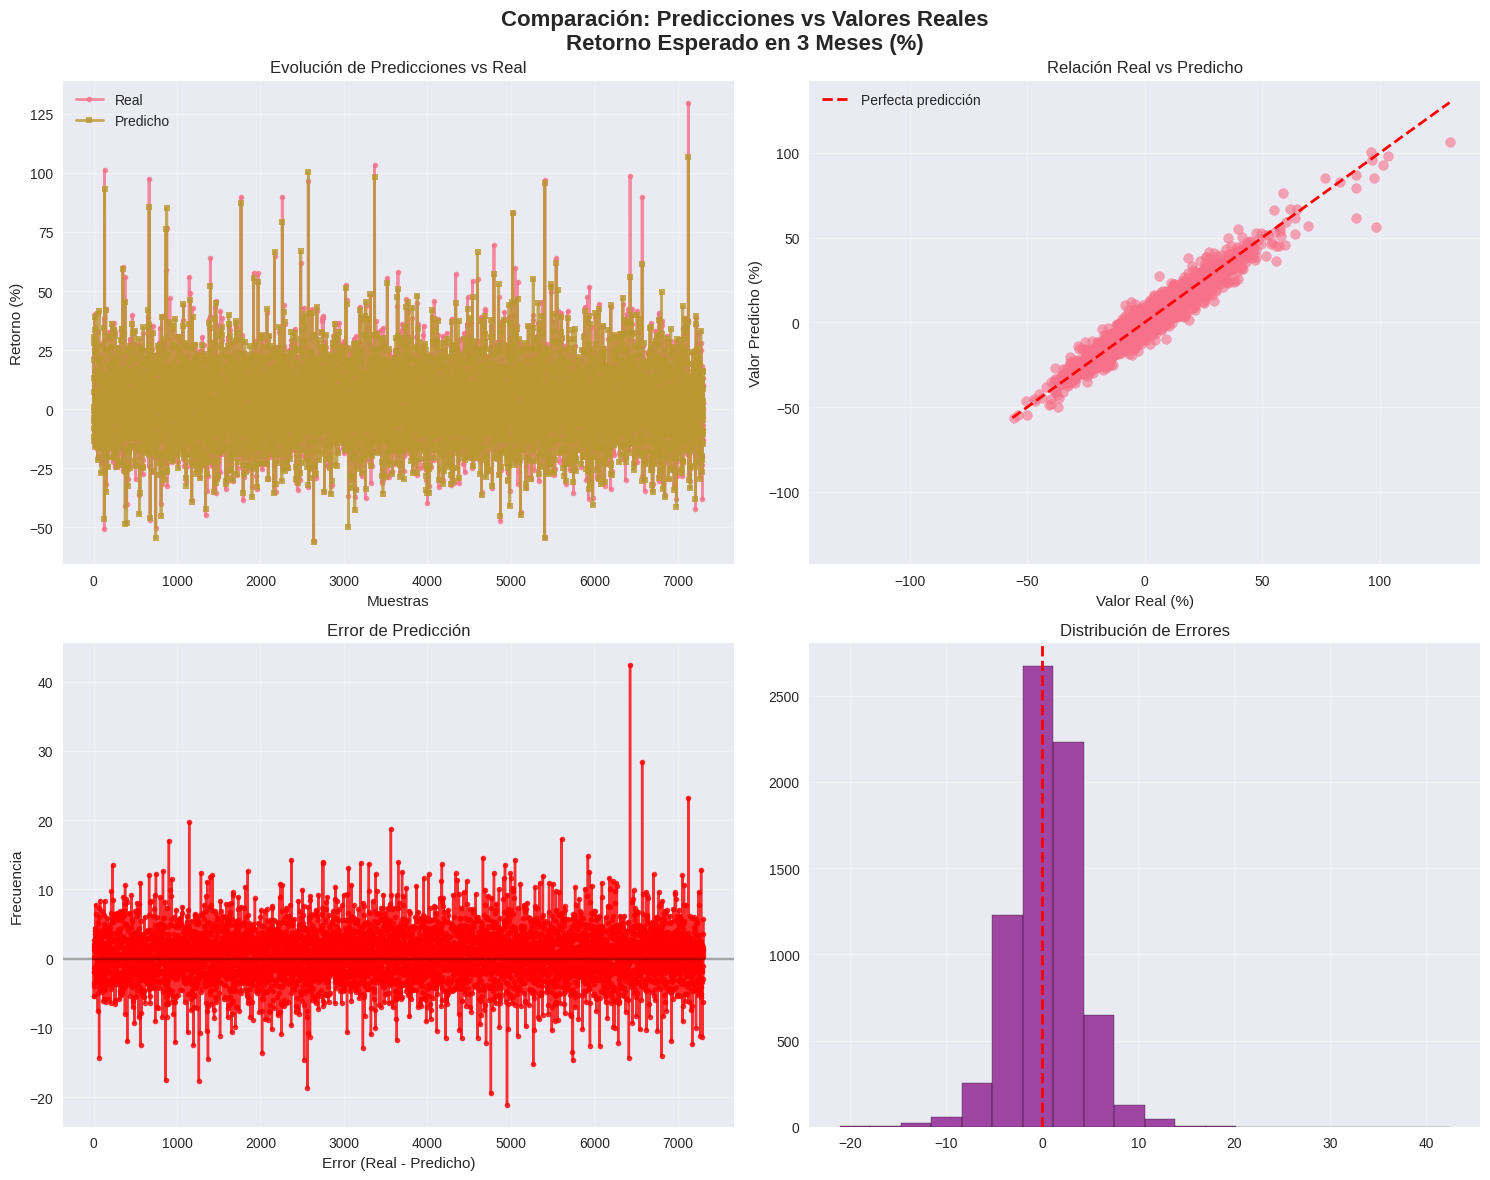

In [300]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación: Predicciones vs Valores Reales\nRetorno Esperado en 3 Meses (%)',
             fontsize=16, fontweight='bold')

# 1. Gráfico de líneas comparativo
axes[0, 0].plot(actual, label='Real', marker='o', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].plot(predicted, label='Predicho', marker='s', markersize=4, linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Muestras')
axes[0, 0].set_ylabel('Retorno (%)')
axes[0, 0].set_title('Evolución de Predicciones vs Real')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot con línea de perfecta predicción
max_val = max(max(predicted), max(actual))
min_val = min(min(predicted), min(actual))
limit = max(abs(max_val), abs(min_val)) * 1.1

axes[0, 1].scatter(actual, predicted, alpha=0.6, s=50)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfecta predicción')
axes[0, 1].set_xlabel('Valor Real (%)')
axes[0, 1].set_ylabel('Valor Predicho (%)')
axes[0, 1].set_title('Relación Real vs Predicho')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-limit, limit)
axes[0, 1].set_ylim(-limit, limit)

# 3. Gráfico de error (diferencia)
error = np.array(actual) - np.array(predicted)
axes[1, 0].plot(error, marker='o', markersize=4, color='red', alpha=0.8)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('Muestras')
axes[1, 0].set_ylabel('Error (Real - Predicho)')
axes[1, 0].set_title('Error de Predicción')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histograma de errores
axes[1, 1].hist(error, bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Error (Real - Predicho)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Errores')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## COMPROBACIÓN MODULO

In [306]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def get_first_sequence_for_prediction(df, lookback=60):
    """
    Obtiene la primera secuencia válida para predicción

    Args:
        ticker_file: Ruta al archivo CSV del ticker
        lookback: Número de días históricos para la secuencia

    Returns:
        Primera secuencia escalada y datos originales
    """
    # Cargar datos
    # df = pd.read_csv(ticker_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # Determinar columnas de features
    feature_columns = df.drop(['Date', 'Target_Direction', 'Target_3M_Return'],
                            axis=1, errors='ignore').columns.tolist()

    print(f"Usando {len(feature_columns)} features: {feature_columns}")

    # Extraer features
    features = df[feature_columns].values

    # Escalar features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Obtener la PRIMERA secuencia completa (cambió aquí)
    first_sequence = features_scaled[:lookback]  # Primeros 'lookback' elementos

    # Verificar que no hay NaN
    if np.any(np.isnan(first_sequence)):
        print("Advertencia: La secuencia contiene valores NaN")
        first_sequence = np.nan_to_num(first_sequence)

    # Información adicional (ahora de la primera secuencia)
    first_date = df['Date'].iloc[lookback - 1]  # Fecha del último elemento de la primera secuencia
    first_close = df['Close'].iloc[lookback - 1] if 'Close' in df.columns else None
    start_date = df['Date'].iloc[0]  # Fecha de inicio de la secuencia

    return {
        'sequence': first_sequence,
        'first_date': first_date,        # Fecha del último elemento de la secuencia
        'start_date': start_date,        # Fecha del primer elemento de la secuencia
        'first_close': first_close,
        'feature_names': feature_columns,
        'scaler': scaler,
        'original_data': df
    }

# Ejemplo de uso
ticker_file = './data_augmentation/GOOGL_completo_arreglado.csv'
lookback=60
df = pd.read_csv(ticker_file)

google_data = get_first_sequence_for_prediction(df=df, lookback=lookback)
print(f"Fecha de inicio de secuencia: {google_data['start_date']}")
print(f"Fecha del último elemento de la secuencia: {google_data['first_date']}")
print(f"Precio de cierre en esa fecha: {google_data['first_close']}")
print(f"Shape de la secuencia: {google_data['sequence'].shape}")
print(f"Valor real {df.iloc[lookback - 1]['Target_3M_Return']}")

Usando 88 features: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI', 'STOCH_K', 'STOCH_D', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ADX', 'CCI', 'WILLR', 'ULTOSC', 'ROC', 'ATR', 'NATR', 'TRANGE', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'MOM', 'PPO', 'APO', 'AROON_Up', 'AROON_Down', 'AROONOSC', 'BOP', 'Price_Change', 'High_Low_Ratio', 'Close_Open_Ratio', 'Free_Cash_Flow', 'Operating_Cash_Flow', 'Investing_Cash_Flow', 'Financing_Cash_Flow', 'Beginning_Cash_Position', 'End_Cash_Position', 'Changes_In_Cash', 'Cash_And_Cash_Equivalents', 'Net_Income', 'Pretax_Income', 'Total_Revenue', 'Operating_Revenue', 'Normalized_Income', 'Net_Income_Common_Stockholders', 'Net_Income_From_Continuing_Operations', 'Net_Income_From_Continuing_And_Discontinued_Operation', 'Net_Income_Including_Noncontrolling_Interests', 'Net_Income_Continuous_Operations', 'Diluted_NI_Availto_Com_Stockholders', 'Net_Income_From_Continuing_Operation_Net_Minority_Interest', 'Basic_EPS', 'Diluted_E

In [307]:
def predict_future_return(model, sequence_data, device=None):
    """
    Predice el retorno futuro usando el modelo GRU

    Args:
        model: Modelo GRU entrenado
        sequence_data: Datos de la secuencia obtenidos con get_last_sequence_for_prediction
        device: Dispositivo (cuda/cpu)

    Returns:
        Predicción del retorno porcentual
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    model.to(device)

    # Preparar la secuencia para el modelo
    sequence = sequence_data['sequence']
    sequence_tensor = torch.FloatTensor(sequence).unsqueeze(0)  # Add batch dimension
    sequence_tensor = sequence_tensor.to(device)

    # Hacer predicción
    with torch.no_grad():
        prediction = model(sequence_tensor)
        predicted_return = prediction.item()

    return predicted_return

# Ejemplo de uso
predicted_return = predict_future_return(rnn_model, google_data)
print(f"Predicción RNN de retorno: {predicted_return:.2f}%")


# Ejemplo de uso
predicted_return = predict_future_return(lstm_model, google_data)
print(f"Predicción LSTM de retorno: {predicted_return:.2f}%")

# Ejemplo de uso
predicted_return = predict_future_return(gru_model, google_data)
print(f"Predicción GRU de retorno: {predicted_return:.2f}%")

Predicción RNN de retorno: -4.84%
Predicción LSTM de retorno: -26.91%
Predicción GRU de retorno: -22.11%


## PREDICIENDO EL FUTURO

### ACCION GOOGLE

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def get_last_sequence_for_prediction(ticker_file, lookback=60):
    """
    Obtiene la última secuencia válida para predicción

    Args:
        ticker_file: Ruta al archivo CSV del ticker
        lookback: Número de días históricos para la secuencia
        feature_columns: Columnas a usar como features (si None, usa todas excepto Date y targets)

    Returns:
        Última secuencia escalada y datos originales
    """
    # Cargar datos
    df = pd.read_csv(ticker_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # Determinar columnas de features
    # if feature_columns is None:
    feature_columns = df.drop(['Date', 'Target_Direction', 'Target_3M_Return'],
                            axis=1, errors='ignore').columns.tolist()

    print(f"Usando {len(feature_columns)} features: {feature_columns}")

    # Extraer features
    features = df[feature_columns].values

    # Escalar features (usando los mismos parámetros que en entrenamiento)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Obtener la última secuencia completa
    last_sequence = features_scaled[-lookback:]

    # Verificar que no hay NaN
    if np.any(np.isnan(last_sequence)):
        print("Advertencia: La secuencia contiene valores NaN")
        last_sequence = np.nan_to_num(last_sequence)

    # Información adicional
    last_date = df['Date'].iloc[-1]
    last_close = df['Close'].iloc[-1] if 'Close' in df.columns else None

    return {
        'sequence': last_sequence,
        'last_date': last_date,
        'last_close': last_close,
        'feature_names': feature_columns,
        'scaler': scaler,
        'original_data': df
    }

# Ejemplo de uso
googl_data = get_last_sequence_for_prediction('./data_augmentation_unknow_values/GOOGL_completo_arreglado.csv', lookback=60)
print(f"Última fecha disponible: {googl_data['last_date']}")
print(f"Último precio de cierre: {googl_data['last_close']}")
print(f"Shape de la secuencia: {googl_data['sequence'].shape}")

Usando 88 features: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI', 'STOCH_K', 'STOCH_D', 'MACD', 'MACD_Signal', 'MACD_Hist', 'ADX', 'CCI', 'WILLR', 'ULTOSC', 'ROC', 'ATR', 'NATR', 'TRANGE', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'MOM', 'PPO', 'APO', 'AROON_Up', 'AROON_Down', 'AROONOSC', 'BOP', 'Price_Change', 'High_Low_Ratio', 'Close_Open_Ratio', 'Free_Cash_Flow', 'Operating_Cash_Flow', 'Investing_Cash_Flow', 'Financing_Cash_Flow', 'Beginning_Cash_Position', 'End_Cash_Position', 'Changes_In_Cash', 'Cash_And_Cash_Equivalents', 'Net_Income', 'Pretax_Income', 'Total_Revenue', 'Operating_Revenue', 'Normalized_Income', 'Net_Income_Common_Stockholders', 'Net_Income_From_Continuing_Operations', 'Net_Income_From_Continuing_And_Discontinued_Operation', 'Net_Income_Including_Noncontrolling_Interests', 'Net_Income_Continuous_Operations', 'Diluted_NI_Availto_Com_Stockholders', 'Net_Income_From_Continuing_Operation_Net_Minority_Interest', 'Basic_EPS', 'Diluted_E

In [304]:
def predict_future_return(model, sequence_data, device=None):
    """
    Predice el retorno futuro usando el modelo GRU

    Args:
        model: Modelo GRU entrenado
        sequence_data: Datos de la secuencia obtenidos con get_last_sequence_for_prediction
        device: Dispositivo (cuda/cpu)

    Returns:
        Predicción del retorno porcentual
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    model.to(device)

    # Preparar la secuencia para el modelo
    sequence = sequence_data['sequence']
    sequence_tensor = torch.FloatTensor(sequence).unsqueeze(0)  # Add batch dimension
    sequence_tensor = sequence_tensor.to(device)

    # Hacer predicción
    with torch.no_grad():
        prediction = model(sequence_tensor)
        predicted_return = prediction.item()

    return predicted_return

# Ejemplo de uso
predicted_return = predict_future_return(rnn_model, googl_data)
print(f"Predicción RNN de retorno: {predicted_return:.2f}%")


# Ejemplo de uso
predicted_return = predict_future_return(lstm_model, googl_data)
print(f"Predicción LSTM de retorno: {predicted_return:.2f}%")

# Ejemplo de uso
predicted_return = predict_future_return(gru_model, googl_data)
print(f"Predicción GRU de retorno: {predicted_return:.2f}%")

Predicción RNN de retorno: 6.32%
Predicción LSTM de retorno: 9.12%
Predicción GRU de retorno: 6.50%


```bash
DATA REAL:
Date,Open,High,Low,Close,Volume
2025-07-09,175.25,179.44000244140625,172.77000427246094,176.6199951171875,43025600
```

In [305]:
precio_2025_04_11 = 157.13999938964844
precio_2025_07_09 =  176.6199951171875

retorno_real = (precio_2025_07_09-precio_2025_04_11)/precio_2025_07_09
print(retorno_real*100)

11.029326387770576
